In [1]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def textwidth_to_inch(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    return fig_width_pt*inches_per_pt*scale         # width in inches

def figsize(scale):
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = textwidth_to_inch(scale)
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    'axes.titlesize': 10,
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import glob
import os

from math import log
from subprocess import call
from networkit import *

import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams.update(pgf_with_latex)

In [2]:
data = {}
files = glob.glob(os.path.expanduser("~/dev/ma/data/results/seq_louvain/*.json")) + glob.glob(os.path.expanduser("~/dev/ma/data/results/dlm_all/*.json")) + glob.glob(os.path.expanduser("~/dev/ma/data/results/plm_all/*.json"))

for path in files:
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

algorithm_names = {
    'thrill partitioned louvain': 'DLPLM',
    'thrill node based fully distributed local moving': 'DLSLM'
}

frames['algorithm_run'].replace({ 'algorithm': algorithm_names }, inplace=True)

frames['program_run']['graph_path'] = frames['program_run']['graph']

graph_names = {
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000-sorted-preprocessed-*.bin': 'LFR 100K', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_1000000-preprocessed-*.bin': 'LFR 1M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_10000000-preprocessed-*.bin': 'LFR 10M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000000-preprocessed-*.bin': 'LFR 100M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_200000000-sorted-preprocessed-*.bin': 'LFR 200M', 
    '/home/kit/iti/kp0036/graphs/hypercubegraph23-preprocessed-*.bin': 'hypercube', 
    '/home/kit/iti/kp0036/graphs/uk-2002.metis-preprocessed-*.bin': 'uk-2002', 
    '/home/kit/iti/kp0036/graphs/uk-2007-05.metis-preprocessed-*.bin': 'uk-2007-05', 
    '/home/kit/iti/kp0036/graphs/in-2004.metis-preprocessed-*.bin': 'in-2004', 
    '/home/kit/iti/kp0036/graphs/com-friendster-preprocessed-*.bin': 'com-friendster', 
    '/home/kit/iti/kp0036/graphs/com-lj.ungraph-preprocessed-*.bin': 'com-lj', 
    '/home/kit/iti/kp0036/graphs/com-orkut.ungraph-preprocessed-*.bin': 'com-orkut', 
    '/home/kit/iti/kp0036/graphs/com-youtube.ungraph-preprocessed-*.bin': 'com-youtube', 
    '/home/kit/iti/kp0036/graphs/com-amazon.ungraph-preprocessed-*.bin': 'com-amazon'
}

frames['program_run'].replace({ 'graph': graph_names }, inplace=True)

In [3]:
frames['algorithm_run']['algorithm'].unique()

array(['sequential louvain', 'DLSLM', 'DLPLM'], dtype=object)

In [25]:
algo_to_path = {
    'DLPLM': 'plm_all',
    'DLSLM': 'dlm_all',
    'sequential louvain': 'seq_louvain'
}

def siml(x):
    if x['graph_path'][:39] != '/home/kit/iti/kp0036/graphs/mu-04/graph':
        return pd.Series([np.NaN, np.NaN, np.NaN])
    
    files = sorted(glob.glob(os.path.expanduser("~/dev/ma/data/graphs/mu-04/part" + x['graph_path'][39:])))
    call("cat {} > tmp".format(' '.join(files)), shell=True)
    ground_truth = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
    call("rm tmp", shell=True)
    
    if 'seq' in x['binary']:
        clustering = community.readCommunities('~/dev/ma/data/results/{}/'.format(algo_to_path[x['algorithm']]) + x['path'])
    else: 
        files = sorted(glob.glob(os.path.expanduser('~/dev/ma/data/results/{}/'.format(algo_to_path[x['algorithm']]) + x['path'].replace('@@@@-#####', '*'))))
        if not files:
            return pd.Series([np.NaN, np.NaN])
        call("cat {} > tmp".format(' '.join(files)), shell=True)
        clustering = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
        call("rm tmp", shell=True)
        
    g = graph.Graph(ground_truth.numberOfElements())
    nmi = 1.0 - community.NMIDistance().getDissimilarity(g, clustering, ground_truth)
    ari = 1.0 - community.AdjustedRandMeasure().getDissimilarity(g, clustering, ground_truth)
    return pd.Series([nmi, ari, clustering.numberOfSubsets()])
    
frames['clustering'][['NMI', 'ARI', 'cluster_count']] = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .apply(siml, axis=1)

path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855675.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855675.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828067.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828067.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855674.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855674.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828495.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828495.part
path expanded to: /home/eagle/dev/ma/data/results/seq_l

In [6]:
seq_first_results = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.binary.str.contains('seq')] \
    .groupby('graph')['path'].first().dropna()

def siml_seq(x):
    if not os.path.isfile('/home/eagle/dev/ma/data/results/seq_louvain/' + x['seq_ground']):
        return pd.Series([np.NaN, np.NaN])
    ground_truth = community.readCommunities('~/dev/ma/data/results/seq_louvain/' + x['seq_ground'])
    
    if 'seq' in x['binary']:
        if x['path'] == x['seq_ground'] or not os.path.isfile('/home/eagle/dev/ma/data/results/{}/'.format(algo_to_path[x['algorithm']]) + x['path']):
            return pd.Series([np.NaN, np.NaN])
        clustering = community.readCommunities('~/dev/ma/data/results/{}/'.format(algo_to_path[x['algorithm']]) + x['path'])
    else: 
        files = sorted(glob.glob(os.path.expanduser('~/dev/ma/data/results/{}/'.format(algo_to_path[x['algorithm']]) + x['path'].replace('@@@@-#####', '*'))))
        if not files:
            return pd.Series([np.NaN, np.NaN])
        call("cat {} > tmp".format(' '.join(files)), shell=True)
        clustering = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
        call("rm tmp", shell=True)
        
    g = graph.Graph(ground_truth.numberOfElements())
    nmi = 1.0 - community.NMIDistance().getDissimilarity(g, clustering, ground_truth)
    ari = 1.0 - community.AdjustedRandMeasure().getDissimilarity(g, clustering, ground_truth)
    return pd.Series([nmi, ari])
    
frames['clustering'][['NMI_seq', 'ARI_seq']] = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(pd.DataFrame({ 'seq_ground': seq_first_results }), left_on='graph', right_index=True) \
    .apply(siml_seq, axis=1)

path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862990.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862989.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11862989.part
path expanded to: /home/eagle/dev/ma/data/results/seq_l

path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855683.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11855683.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
path expanded to: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
read communities from: /home/eagle/dev/ma/data/results/seq_louvain/clusterings/seq-11828496.part
path expanded to: /home/eagle/dev/ma/data/results/seq_l

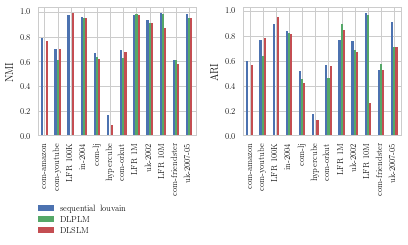

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(textwidth_to_inch(1.1), textwidth_to_inch(0.4)));
plt.subplots_adjust(wspace=0.3);

pad = 5

for (i, measure) in [(0, 'NMI'), (1, 'ARI')]:
    frames['clustering'] \
        .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
        .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
        .groupby(['graph', 'algorithm'])['{}_seq'.format(measure)].mean().dropna().unstack()[['sequential louvain', 'DLPLM', 'DLSLM']] \
        .loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()] \
        .dropna(how='all') \
        .plot.bar(legend=False, ax=axes[i])

    axes[i].set_ylabel(measure)
    axes[i].set_xlabel('')

plt.legend(loc = 'lower left', bbox_to_anchor = (0.11,-0.5,1,1), bbox_transform = plt.gcf().transFigure)
savefig("lfr_size_seq")

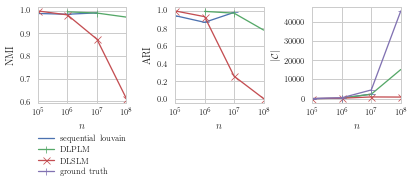

In [33]:
sns.set_context(rc={'lines.markeredgewidth': 0.75, 'lines.linewidth': 1.3, 'lines.markersize': 7})

fig, axes = plt.subplots(1, 3, figsize=(textwidth_to_inch(1.1), textwidth_to_inch(0.3)));
plt.subplots_adjust(wspace=0.55);

pad = 5

for (i, measure) in [(0, 'NMI'), (1, 'ARI'), (2, 'cluster_count')]:
    sml = frames['clustering'] \
        .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
        .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
        .loc[lambda x: x['graph'].str.contains('LFR')] \
        .loc[lambda x: x['node_count'] < 200000000] \
        .groupby(['node_count', 'algorithm'])[measure].mean().dropna().unstack()
    
    sml['sequential louvain'].plot(logx=True, legend=False, ax=axes[i], marker='_')
    sml['DLPLM'].plot(logx=True, legend=False, ax=axes[i], marker='|')
    sml['DLSLM'].plot(logx=True, legend=False, ax=axes[i], marker='x')
    
    if measure == 'cluster_count':
        axes[i].set_ylabel('$|\mathcal{C}|$')
    else:
        axes[i].set_ylabel(measure)
    axes[i].set_xlabel("$n$")
    axes[i].xaxis.set_ticks([100000, 1000000, 10000000, 100000000])
    
pd.DataFrame([{ 'node_count': 100000, 'ground truth': 49 },
              { 'node_count': 1000000, 'ground truth': 457 },
              { 'node_count': 10000000, 'ground truth': 4542 },  
              { 'node_count': 100000000, 'ground truth': 45653 }]) \
    .set_index('node_count').plot(logx=True, legend=False, ax=axes[2], marker='+')
axes[2].set_ylabel('$|\mathcal{C}|$')
axes[2].set_xlabel("$n$")
axes[2].xaxis.set_ticks([100000, 1000000, 10000000, 100000000])

plt.legend(loc = 'lower left', bbox_to_anchor = (0.11,-0.5,1,1), bbox_transform = plt.gcf().transFigure)
savefig("lfr_size")